In [6]:
!pip install importnb

   ---------------------------------------- 0.0/46.0 kB ? eta -:--:--
   -------------------------- ------------- 30.7/46.0 kB 660.6 kB/s eta 0:00:01
   ---------------------------------------- 46.0/46.0 kB 760.8 kB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import time
import numpy as np
import os  # Import os
from importnb import Notebook
import config  # Import your configuration

with Notebook():
    from action_conditioned_diffusion_world_model_gemini import SimpleUNet, forward_diffusion_sample, linear_beta_schedule, cosine_beta_schedule  # Import necessary functions
    from jetbot_dataset import *

In [15]:
# --- Helper Function for Displaying PIL Images in Subplots ---
def display_frame_pil(pil_frame, ax, title=None):
    """Displays a PIL Image on a matplotlib Axes object."""
    ax.imshow(pil_frame)
    ax.axis('off')
    if title:
        ax.set_title(title)

def test_multistep_prediction(model, initial_frame, actions, betas, alphas_cumprod, num_timesteps, device, num_prev_frames, image_size, display=True):
    """
    Tests multi-step prediction, displaying frames using matplotlib subplots.

    Args:
        model: Trained diffusion model (U-Net).
        initial_frame: Starting frame (PIL Image).
        actions: Tensor of actions (shape: (n, 1)).
        betas: Beta values for diffusion.
        alphas_cumprod: Cumulative product of alphas.
        num_timesteps: Number of diffusion timesteps.
        device: Device (CPU or GPU).
        num_prev_frames: Number of previous frames used by the model.
        image_size: Image size (used for transform, less critical for display now).
        output_dir: Base output directory (used if saving is re-enabled).
        display: Whether to display the plot using matplotlib.

    Returns:
        A list of PIL Images representing the predicted frames.
    """

    model.eval()
    num_steps = actions.shape[0]
    predicted_frames = [] # Will store PIL Images

    # Transform initial frame for model input
    transform_to_tensor = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    current_frame_tensor = transform_to_tensor(initial_frame).unsqueeze(0).to(device) # (1, C, H, W)

    # Initialize prev_frames with copies of the initial frame tensor
    prev_frames_tensor = torch.cat([current_frame_tensor] * num_prev_frames, dim=1)

    start_time = time.time()

    with torch.no_grad():
        for step in range(num_steps):
            action = actions[step].unsqueeze(0).to(device)
            t_sample = torch.tensor([num_timesteps - 1], device=device, dtype=torch.long)

            # Noise the *current* frame tensor
            x_noisy, _ = forward_diffusion_sample(current_frame_tensor, t_sample, betas, alphas_cumprod, device)
            x = x_noisy

            # Denoise (sample) to predict the next frame
            for i in reversed(range(1, num_timesteps)):
                t = (torch.ones(1) * i).long().to(device)
                with torch.cuda.amp.autocast(enabled=config.USE_FP16):
                    # Use prev_frames_tensor here
                    predicted_noise = model(x, t, action, prev_frames_tensor)

                alpha = alphas[t][:, None, None, None]
                alpha_hat = alphas_cumprod[t][:, None, None, None]
                beta = betas[t][:, None, None, None]

                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise

            # Un-normalize predicted frame tensor
            predicted_frame_tensor_unnorm = (x.clamp(-1, 1) + 1) / 2 # Range [0, 1]
            # Convert to PIL Image for storage and display
            predicted_frame_pil = transforms.ToPILImage()(predicted_frame_tensor_unnorm[0].cpu()).convert("RGB")
            predicted_frames.append(predicted_frame_pil)

            # Update current_frame_tensor and prev_frames_tensor for the next step
            # Use the unnormalized tensor before converting to uint8 for re-normalization
            current_frame_tensor_next_step = transforms.ToTensor()(predicted_frame_pil).unsqueeze(0) # Range [0, 1]
            current_frame_tensor_next_step = (current_frame_tensor_next_step - 0.5) / 0.5 # Normalize back to [-1, 1]
            current_frame_tensor = current_frame_tensor_next_step.to(device)
            prev_frames_tensor = torch.cat([prev_frames_tensor[:, 3:, :, :], current_frame_tensor], dim=1)


    end_time = time.time()
    total_time = end_time - start_time
    print(f"Generated {num_steps} frames in {total_time:.4f} seconds")
    print(f"Average time per frame: {total_time / num_steps:.4f} seconds")

    # --- Display using Matplotlib ---
    if display:
        num_cols = num_steps + 1 # Initial frame + N predicted steps
        fig, axes = plt.subplots(1, num_cols, figsize=(5 * num_cols, 5.5)) # Adjusted figsize slightly

        # Display initial frame using the helper
        display_frame_pil(initial_frame, axes[0], title="Initial Frame")

        # Display predicted frames using the helper
        for i, frame in enumerate(predicted_frames):
            display_frame_pil(frame, axes[i + 1], title=f"Step {i+1}\nAction: {actions[i].item():.2f}") # Display action

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
        plt.show()

    # --- Optional: Save combined image (if needed later) ---
    # You can uncomment this section if you still want the combined image saved
    # test_output_dir = os.path.join(output_dir, "test_output")
    # os.makedirs(test_output_dir, exist_ok=True)
    # total_width = (num_steps + 1) * image_size
    # max_height = image_size
    # combined_image = Image.new('RGB', (total_width, max_height))
    # x_offset = 0
    # combined_image.paste(initial_frame, (x_offset, 0))
    # x_offset += image_size
    # for frame in predicted_frames:
    #     combined_image.paste(frame, (x_offset, 0))
    #     x_offset += image_size
    # combined_image.save(os.path.join(test_output_dir, "multistep_prediction_combined.png"))
    # print(f"Saved combined prediction image to {test_output_dir}")


    return predicted_frames # Return the list of PIL images



In [18]:
model = SimpleUNet(num_prev_frames=config.NUM_PREV_FRAMES).to(config.DEVICE)
checkpoint_path = os.path.join(config.CHECKPOINT_DIR, 'model_best_epoch_62.pth')  # Example path. Use the *actual* path.
checkpoint = torch.load(checkpoint_path, map_location=config.DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Load diffusion parameters (MUST BE THE SAME AS TRAINING)
if config.SCHEDULE_TYPE == 'linear':
    betas = linear_beta_schedule(config.NUM_TIMESTEPS, config.BETA_START, config.BETA_END).to(config.DEVICE)
elif config.SCHEDULE_TYPE == 'cosine':
    betas = cosine_beta_schedule(config.NUM_TIMESTEPS).to(config.DEVICE)
else:
    raise ValueError(f"Invalid SCHEDULE_TYPE: {config.SCHEDULE_TYPE}")

alphas = (1. - betas).to(config.DEVICE)
alphas_cumprod = torch.cumprod(alphas, axis=0).to(config.DEVICE)

# --- Create Dataset and DataLoader ---
dataset = JetbotDataset(config.CSV_PATH, config.DATA_DIR, config.IMAGE_SIZE, config.NUM_PREV_FRAMES, transform=config.TRANSFORM)



Loaded combined CSV with columns: ['session_id', 'image_path', 'timestamp', 'action']
Total rows in CSV: 23081, Valid sequence start indices: 23037


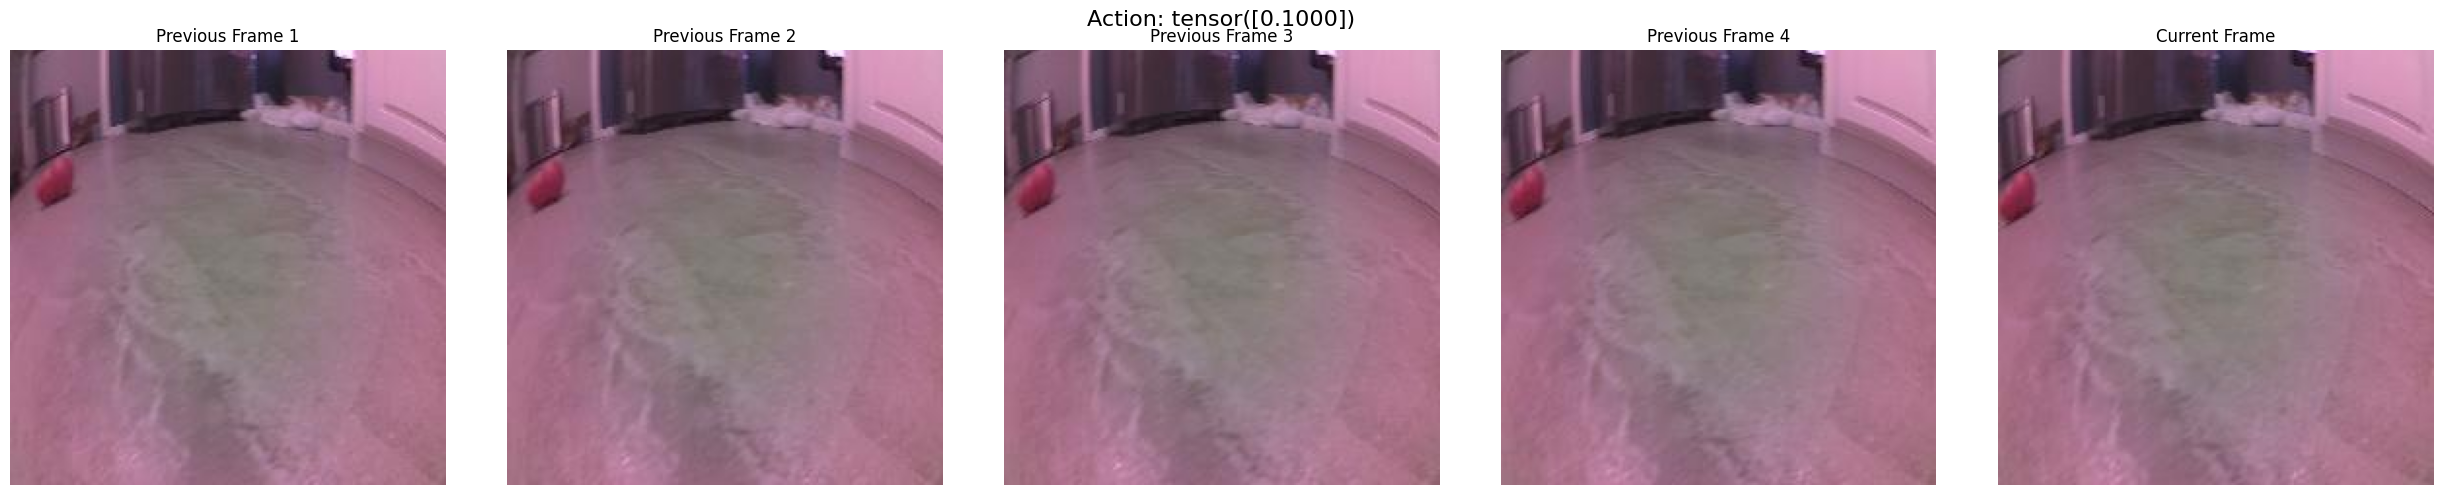

Generated 4 frames in 22.4195 seconds
Average time per frame: 5.6049 seconds


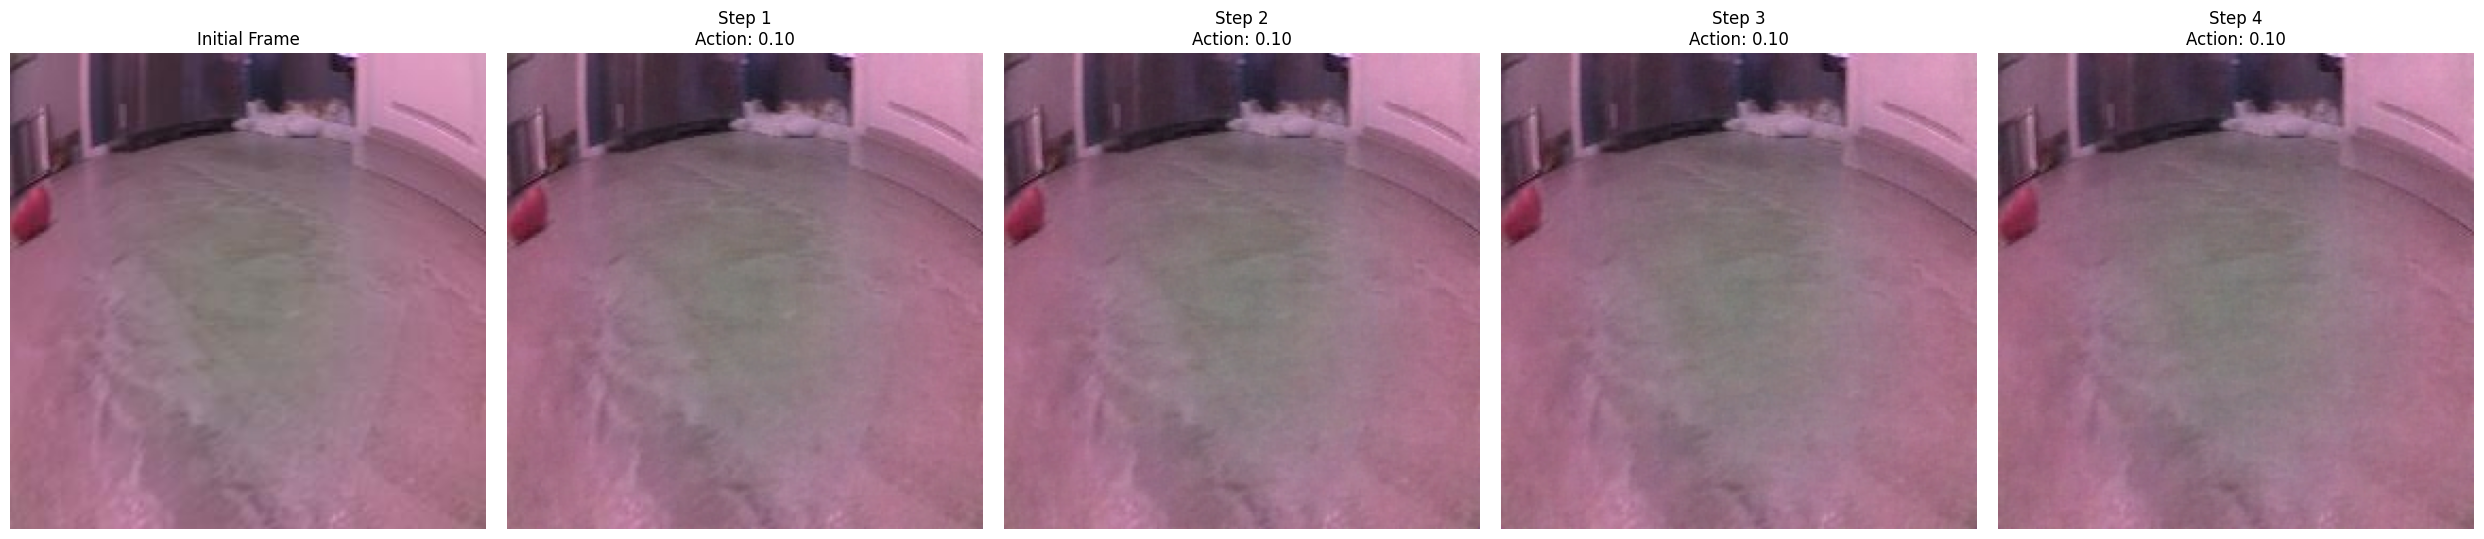

In [20]:
entry = dataset[2004]
image, _, _ = entry

display_dataset_entry(entry)
# Convert the tensor back to a PIL Image
initial_frame = transforms.ToPILImage()(((image.clamp(-1, 1) + 1) / 2 * 255).type(torch.uint8)).convert("RGB")

# Create a sequence of actions
num_steps = 5
actions = torch.tensor([[0.1], [0.1], [0.1], [0.1]], dtype=torch.float32)

# Call the prediction function
predicted_frames = test_multistep_prediction(
    model, initial_frame, actions, betas, alphas_cumprod,
    config.NUM_TIMESTEPS, config.DEVICE, config.NUM_PREV_FRAMES, config.IMAGE_SIZE
)

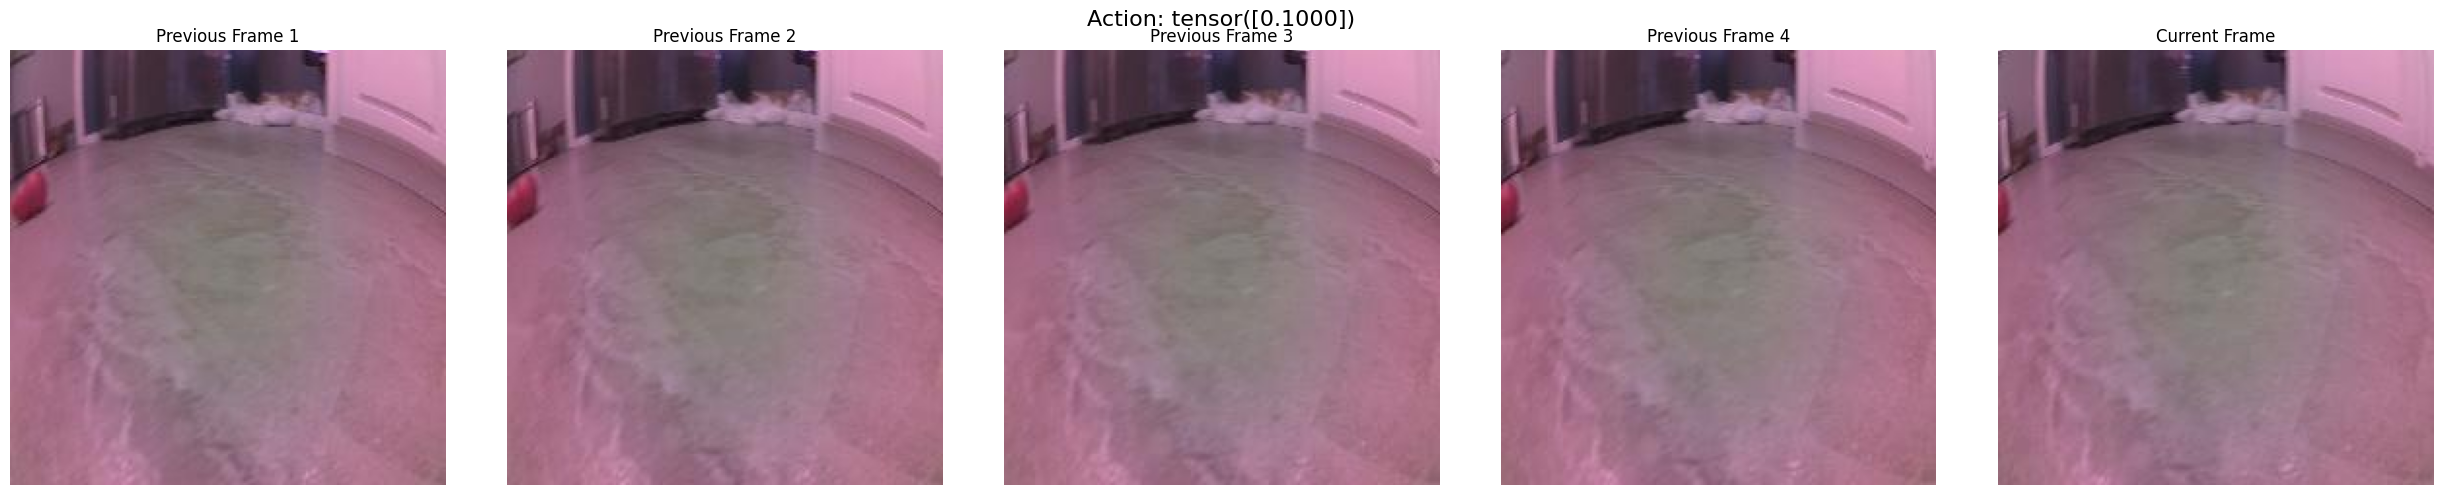

In [21]:
actual = dataset[2008]
display_dataset_entry(actual)

In [15]:
dataset = JetbotDataset(config.IMAGE_DIR, config.CSV_PATH, config.IMAGE_SIZE, config.NUM_PREV_FRAMES, transform=config.TRANSFORM)
image, _, _ = dataset[25]

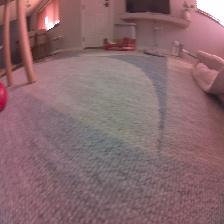

In [25]:
image
transforms.ToPILImage()(((image.clamp(-1, 1) + 1) / 2 * 255).type(torch.uint8)).convert("RGB")

In [9]:
image_clamped = (image.clamp(-1, 1) + 1) / 2
image_clamped

tensor([[[0.3804, 0.3843, 0.4039,  ..., 0.9961, 0.9961, 0.9961],
         [0.3804, 0.3686, 0.3804,  ..., 0.9961, 0.9961, 0.9961],
         [0.4196, 0.3922, 0.3804,  ..., 0.9961, 0.9961, 0.9961],
         ...,
         [0.5059, 0.4941, 0.4392,  ..., 0.4039, 0.4196, 0.3961],
         [0.4902, 0.4980, 0.4627,  ..., 0.3922, 0.4235, 0.4196],
         [0.4706, 0.5059, 0.4902,  ..., 0.3765, 0.4196, 0.4314]],

        [[0.2392, 0.2431, 0.2510,  ..., 0.9961, 0.9961, 0.9961],
         [0.2275, 0.2157, 0.2275,  ..., 0.9961, 0.9961, 0.9961],
         [0.2627, 0.2353, 0.2235,  ..., 0.9961, 0.9961, 0.9961],
         ...,
         [0.3961, 0.3843, 0.3294,  ..., 0.3059, 0.3216, 0.2980],
         [0.3804, 0.3882, 0.3529,  ..., 0.2941, 0.3255, 0.3216],
         [0.3608, 0.3961, 0.3804,  ..., 0.2784, 0.3216, 0.3333]],

        [[0.2471, 0.2510, 0.2549,  ..., 0.9961, 0.9961, 0.9961],
         [0.2392, 0.2196, 0.2314,  ..., 0.9961, 0.9961, 0.9961],
         [0.2667, 0.2392, 0.2275,  ..., 0.9961, 0.9961, 0.

In [10]:
image_255 = (image_clamped * 255).type(torch.uint8)
image_255

tensor([[[ 97,  98, 103,  ..., 254, 254, 254],
         [ 97,  94,  97,  ..., 254, 254, 254],
         [107, 100,  97,  ..., 254, 254, 254],
         ...,
         [129, 126, 112,  ..., 103, 107, 101],
         [125, 127, 118,  ..., 100, 108, 107],
         [120, 129, 125,  ...,  96, 107, 110]],

        [[ 60,  61,  64,  ..., 254, 254, 254],
         [ 57,  54,  57,  ..., 254, 254, 254],
         [ 67,  59,  56,  ..., 254, 254, 254],
         ...,
         [101,  98,  84,  ...,  78,  82,  76],
         [ 97,  99,  90,  ...,  75,  83,  82],
         [ 92, 101,  97,  ...,  71,  82,  85]],

        [[ 62,  64,  65,  ..., 254, 254, 254],
         [ 60,  55,  58,  ..., 254, 254, 254],
         [ 68,  60,  57,  ..., 254, 254, 254],
         ...,
         [116, 113,  98,  ...,  82,  86,  80],
         [112, 114, 104,  ...,  79,  87,  86],
         [107, 116, 111,  ...,  75,  86,  89]]], dtype=torch.uint8)

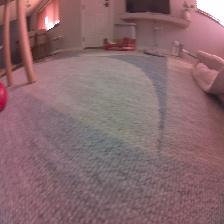

In [12]:
transforms.ToPILImage()(image_255).convert("RGB")